# ALGORITMOS DE EXTRACCIÓN

En este script se encuentran los cuatro algoritmos construidos para extraer información de forma automática

## 0. Imports

In [1]:
import math
import numpy as np
import json
import pandas as pd
import re

import spacy
from spacy import displacy 
from collections import Counter
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

## 1. Background preparation

### 1.1. Load BD

In [2]:
data_path = ''

with open(data_path, encoding="utf8") as fp:
    db = json.loads(fp.read())
    
data = pd.DataFrame(db)

### 1.2. Insert Data_type column

In [3]:
structured_id = ['3', '5', '17', '30', '38', '39', '68', '75', '80', '84']
not_structured_id = ['1', '2', '16', '32', '33', '40', '41', '44', '45', '52', '55', '56', '57', '58', '59', '60', '61', '62', '74', '78', '79', '81', '82', '90', '94', '100', '106']
semi_structured_id = ['4', '6', '9', '10', '13', '15', '21', '27', '31', '35', '36', '37', '42', '63', '66', '76', '77', '83', '87', '88', '91', '92', '103']

df = data.copy()
df['Data_type'] = np.nan

for idx in range(len(df)):
    if df['Plat Id'][idx] in structured_id:
        df['Data_type'][idx] = 'structured'
    if df['Plat Id'][idx] in not_structured_id:
        df['Data_type'][idx] = 'not-structured'
    if df['Plat Id'][idx] in semi_structured_id:
        df['Data_type'][idx] = 'semi-structured'

<ipython-input-3-6935317ea32a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Data_type'][idx] = 'semi-structured'
C:\Users\maram\Anaconda3\Installation\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### 1.3. Select english data

In [4]:
english_data = df[df['Language'] == 'English']
english_data = english_data.reset_index(drop=True)

### 1.4. Select one random sample and clean text

In [5]:
def select_random_sample(data):
    random_sample = data.sample(1)
    df = pd.DataFrame()
    #title
    df['Title'] = random_sample['TITLE']
    #data type
    df['Data_type'] = random_sample['Data_type']
    #Plat country
    df['Country'] = random_sample['Plat country']
    #description
    text_list = random_sample['DESCRIPTION']
    text_list = text_list.tolist()
    text_list = text_list[0]
    text = ''
    for sentence in text_list:
        text = text + sentence
    print(text)
    df['Description'] = text
    
    # = df.reset_index()
    return df

In [6]:
def clean(text):
    
    # removing new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',str(text))
    text = text.replace('\\n',' ')
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("— ",'',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing salutations
    text = re.sub("Mr\.",'Mr',str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))
    # removing any reference to outside text
    #text = re.sub("<\[\(\[].*?[\)\]]>", "", str(text))
    text = re.sub("</a>", "", str(text))
    text = re.sub("<a", "", str(text))    
    return text

## 2. ALGORITHMS

### 2.1. Load Corpus Train

In [7]:
#!python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')

### 2.2. OBJECTIVE

In [8]:
def extract_objective(sample, doc):
    
    objective = None
    #create list of string sentence
    sents_list = []
    for sent in doc.sents:
        sents_list.append(sent.text)
        
    #lemmatizamos las no stop words
    #es una lista de strings 
    words_list = []
    for token in doc:
        if token.is_stop == False and token.is_alpha==True:
            words_list.append(token.lemma_)
                
        
    #palabras clave
    words = ['goal', 'purpose', 'objective', 'intention', 'ambition', 'promote', 'dedicate']
    synonyms = []
    for w in words:
        for synset in wordnet.synsets(w):
            for i in synset.lemmas():
                if i.name() not in synonyms and i.name()!='use':
                    synonyms.append(i.name())
    
    
    
    #Miramos si alguna palabra de la lista words esta en el texto
    for token in doc:
        if token.text in words:
            for sentence in sents_list:
                    if token.text in sentence.split(' '):
                        objective = sentence
                        return objective
    
    
    #Mirar si alguna palabra de words_list esta en synonyms, si lo esta entonces devolver esa frase donde esta esa word
    for token in doc:
        if token.is_stop == False and token.is_alpha==True:
            if (token.text in synonyms) or (token.lemma_ in synonyms):
                for sentence in sents_list:
                    if token.text in sentence.split(' '):
                        objective = sentence
                        return objective
    
    #Mirar la similitud entre las palabras de synonyms y todas las palabras de words_list y si supera un umbral
    #devolver la frase donde esta esa word
    threshold = 0.7
    tokens_list = []
    for token in doc:
        word1 = nlp(token.text)
        for synonym in synonyms:
            word2 = nlp(synonym)
            if word1.similarity(word2) >= threshold:
                tokens_list.append(token.text)
                
                
    for sent in sents_list:
        for tok in tokens_list:
            if tok in sent:
                objective = sent
                return sent

### 2.3. GELOCATION

In [9]:
def extract_location(sample, doc):
    locations = []
    location = []
    for ent in doc.ents:
        if ent.label_ in ['LOC']:
            locations.append(ent.text)
        if ent.label_ in ['GPE']:
            locations.append(ent.text)

        #intento de añadir gentilicios
        '''if ent.label_ in ['NORP']:
            lemmatizer = WordNetLemmatizer()
            word = ent.text
            word = word.lower()
            word = lemmatizer.lemmatize(word)
            locations.append(word)'''

    if len(locations) == 0:
        return None
    
    else:
        locations = Counter(locations).most_common(1)
        for t in locations:
            location.append(t[0])
    
    return location

### 2.4. ORGANIZATION

In [10]:
def extract_organization(sample, doc):
    organizations = []
    organization = []
    for ent in doc.ents:
        if ent.label_ in ['ORG']:
            #si la entidad es identificada como organización pero es igual que el titulo, la descartamos 
            #porque no es una organizacion sino el nombre del proyecto
            if sample['Title'].tolist()[0] not in ent.text:
                if ent not in organizations:
                    organizations.append(ent)
    if len(organizations) == 0:
        return [None]
    else:
        organizations = Counter(organizations).most_common(1)
        for t in organizations:
            organization.append(t[0])

    return organization

### 2.5. PARTICIPANTS

In [11]:
def extract_participants(sample, doc):
    
    sents_list = []
    for sent in doc.sents:
        sents_list.append(sent.text)
    
    categories = ['students', 'University students', 'kids', 'adults', 'community', '18 years', 'group of', 'undergraduate students']
    
    #Gentilicios
    loc = extract_location(rs, doc)
    
    participants = []
    
    for sent in sents_list:
        for category in categories:
            if category in sent:
                participants.append(category)
    
    '''for token in doc:
        if token.text in categories:
            participants.append(token.text)'''
        
    if len(participants) == 0: #Si no especifica devolvemos Anyone
        return "Anyone"
    
    elif categories[6] in participants:
        for sent in doc.sents:
            s = sent.text
            if categories[6] in s:
                words_list = s.split(' ')
                for i in range(len(words_list)):
                    if words_list[i] == 'group' and words_list[i+1] == 'of':
                        return(words_list[i] + ' ' + words_list[i+1] + ' '+ words_list[i+2])
    
    elif categories[4] in participants:
        if loc == None:
                participant = 'Area community'
        else:
            participant = "Area community (" + loc[0] + ')'
        return participant
    
    elif (categories[3] in participants) or (categories[5] in participants): #si existe "adults" o "18 years" se categoriza como adults
        return 'Adults'      
    
    else:
        return participants

### 2.6. DATES

In [12]:
def extract_dates(sample, doc):
    dates = []
    for ent in doc.ents:
        if ent.label_ in ['DATE']:
            dates.append(ent)
        if ent.label_ in ['TIME']:
            dates.append(ent)
    return dates

## 3. PROCESSING TEXT

### 3.1. Select one random text

In [13]:
rs = select_random_sample(english_data)
text = rs['Description'].to_list()
text = clean(text)

MiCorps’ Volunteer Stream Monitoring Program (VSMP) provides technical assistance, training, and grants to volunteer stream monitors in Michigan to ensure that they are collecting reliable, high-quality data. MiCorps works with local organizations to support stream monitoring statewide. Monitoring programs include aquatic macroinvertebrates, habitat, stream flow, and road-stream crossing inventories.Volunteers join through a local MiCorps volunteer stream monitoring organization. Learn more about the program here: https://micorps.net/stream-monitoring/ and find a directory of participating organizations here: https://micorps.net/data/directory_search.phpFollow the Volunteer Stream Monitoring Program


### 3.2. Create nlp

In [14]:
doc = nlp(text)

#para visualizar entidades nombradas del texto
#displacy.render(doc, style='ent')

#para saber que significan las entidades:
#spacy.explain("FAC")

In [15]:
#spacy.explain("GPE")

### 3.3. Apply algorithms

In [16]:
print('LOCATION:', extract_location(rs, doc))
print('ORGANIZATION/S:', extract_organization(rs, doc))
print('DATE/S or DURATION:', extract_dates(rs, doc))
print('PARTICIPANTS: ', extract_participants(rs, doc))

LOCATION: ['Michigan']
ORGANIZATION/S: [None]
DATE/S or DURATION: []
PARTICIPANTS:  Anyone


In [17]:
print('OBJECTIVE: ', extract_objective(rs, doc))

<ipython-input-8-6f01e3647cbd>:54: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if word1.similarity(word2) >= threshold:


OBJECTIVE:  None


## 4. CSV CREATION

### 4.1. Preprocessing

In [18]:
def clean_data(data):
    df = pd.DataFrame()
    #title
    df['Title'] = data['TITLE']
    #data type
    df['Data_type'] = data['Data_type']
    #Plat country
    df['Country'] = data['Plat country']
    #Description
    df['Description'] = data['DESCRIPTION']
    
    #Add algorithms columns
    df['Objective'] = ''
    df['Geolocalization'] = ''
    df['Organization'] = ''
    df['Participants'] = ''
    
    df = df.reset_index()
    
    return df

In [19]:
def create_temp_register(data, index):
    df = pd.DataFrame()
    df = data.iloc[[index]]
    return df

In [20]:
def extract_description(data, index):
    text_list = [data['Description'][index]]
    #text_list = text_list.tolist()
    text_list = text_list[0]
    text = ''
    for sentence in text_list:
        if type(sentence) == str:
            text = text + sentence
        elif type(sentence) == int:
            text = text + str(sentence)
    return text

In [ ]:
d = clean_data(english_data)
text = extract_description(d, 0)
text = clean(text)
#------------
x = create_temp_register(d, 0)
doc = nlp(text)
loc = extract_participants(x, doc)
print(type(loc))

In [22]:
if type(d['Description'][2468]) == float:
    print('yes')

### 4.2. Information extraction (all english data)

In [42]:
def db_creation(data):
    #Select only the columns need it
    imp_data = clean_data(data)
    for i in data.index:
        print(i)
        if type(imp_data['Description'][i]) == float:
            imp_data['Geolocalization'][i] = None
            imp_data['Objective'][i] = None
            imp_data['Organization'][i] = None
            imp_data['Participants'][i] = None
            
        else:
            text = extract_description(imp_data, i)
            text = clean(text)
            doc = nlp(text)
            temp_data = create_temp_register(imp_data, i)
            imp_data['Geolocalization'][i] = extract_location(temp_data, doc)
            #imp_data['Objective'][i] = extract_objective(temp_data, doc)
            imp_data['Organization'][i] = extract_organization(temp_data, doc)
            imp_data['Participants'][i] = extract_participants(temp_data, doc)
    return imp_data
    

In [39]:
def objective_creation(data):
    #Select only the columns need it
    imp_data = clean_data(data)
    objective = [None]*data.index
    for i in range(200):
        print(i)
        if type(imp_data['Description'][i]) == float:
            pass
        else:
            text = extract_description(imp_data, i)
            text = clean(text)
            doc = nlp(text)
            temp_data = create_temp_register(imp_data, i)
            objective[i] = extract_objective(temp_data, doc)
    
    return objective

In [40]:
ie = db_creation(english_data)

0


<ipython-input-35-1131b433df8d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_data['Geolocalization'][i] = extract_location(temp_data, doc)
<ipython-input-35-1131b433df8d>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_data['Organization'][i] = extract_organization(temp_data, doc)
<ipython-input-35-1131b433df8d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_data['Participants'][i] = extract_participants(temp_data

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


<ipython-input-35-1131b433df8d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_data['Geolocalization'][i] = None
<ipython-input-35-1131b433df8d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_data['Objective'][i] = None
<ipython-input-35-1131b433df8d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_data['Organization'][i] = None
<ipython-input-35-1131b433df8d>:10: SettingWithCopyWarning: 
A value is trying to be set on

373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622


2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341


In [43]:
obj_list = objective_creation(english_data)
obj_list

0
1
2
3
4


<ipython-input-8-6f01e3647cbd>:54: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if word1.similarity(word2) >= threshold:


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


["Many of them will be junk, but every now and then you'll find a nice clean image, with no background objects or noise overwhelming the signal.",
 'Join us in meeting our goal of transcribing all of these nest records to better understand and protect birds.',
 'The Stone and Timmons families are encouraged by the FISHstory efforts...',
 'Our goal is that all the names can be found in our online archive.',
 'The current workflow is Emergency Address (Name, Address, Other text, Notified date(s), R. B. Sketch No., Photo No.)I have used the burial cards to help verify the names and numbers reported by the ABMC.',
 'The goal of this project is to measure the winding of spiral arms in galaxies.',
 'With this information, it will be possible to link the occurrence of fish species on paintings and their commercial purpose to certain periods in time.',
 'We actively conduct research, grow the collection, and facilitate entomological research of scientists from other institutions with the goal 

In [49]:
none_list = [None]*(len(english_data)-len(obj_list))
obj_list = obj_list + none_list
obj_list[0]

"Many of them will be junk, but every now and then you'll find a nice clean image, with no background objects or noise overwhelming the signal."

In [51]:
ie['Description'] = english_data['DESCRIPTION']
ie['Objective'] = obj_list

,index,Title,Data_type,Country,Description,Objective,Geolocalization,Organization,Participants
0,0,DISK DETECTIVE,semi-structured,World wide,"[NASA Citizen Science, diskdetective, DiskDete...","Many of them will be junk, but every now and t...",[Los Angeles],[(NASA)],Anyone
1,1,NEST QUEST GO: FLYCATCHERS,semi-structured,World wide,[Choose your own adventure! There are many way...,Join us in meeting our goal of transcribing al...,[Europe],[(NestWatch)],Anyone
2,2,FISHSTORY,semi-structured,World wide,"[""The Stone and Timmons families are encourage...",The Stone and Timmons families are encouraged ...,[Florida],[(Stone)],Anyone
3,3,EVERY NAME COUNTS,semi-structured,World wide,[All the workflows are about transcribing pers...,Our goal is that all the names can be found in...,[Germany],"[(The, Arolsen, Archives)]",Anyone
4,4,AMERICAN WWI BURIAL CARDS,semi-structured,World wide,[The current workflow is Emergency Address (Na...,The current workflow is Emergency Address (Nam...,None,[(Address)],Anyone


### 4.3. CSV

In [52]:
ie.to_csv('InformationExtraction_reduced.csv', index = False, sep=';', encoding='utf-8')

## 5. MOST COMMON WORDS

### 5.1. List to string

In [57]:
text = ''
for i in range(200):
    if obj_list[i] != None:
        text = text + obj_list[i]
        text = text + ' '

### 5.2. Clean text (remove stop words)

In [64]:
from gensim.parsing.preprocessing import STOPWORDS

Add the most tipic words in objective seentences

In [97]:
words = ['goal', 'purpose', 'objective', 'intention', 'ambition', 'promote', 'dedicate', 'aims']
synonyms = []
for w in words:
    for synset in wordnet.synsets(w):
        for i in synset.lemmas():
            if i.name() not in synonyms and i.name()!='use':
                synonyms.append(i.name())

In [98]:
all_stopwords_gensim = STOPWORDS.union(set(synonyms))

In [99]:
clean_text = ''
for word in text.split(' '):
    if word not in all_stopwords_gensim:
        clean_text = clean_text + word + ' '

### 5.2. WordCloud

In [100]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

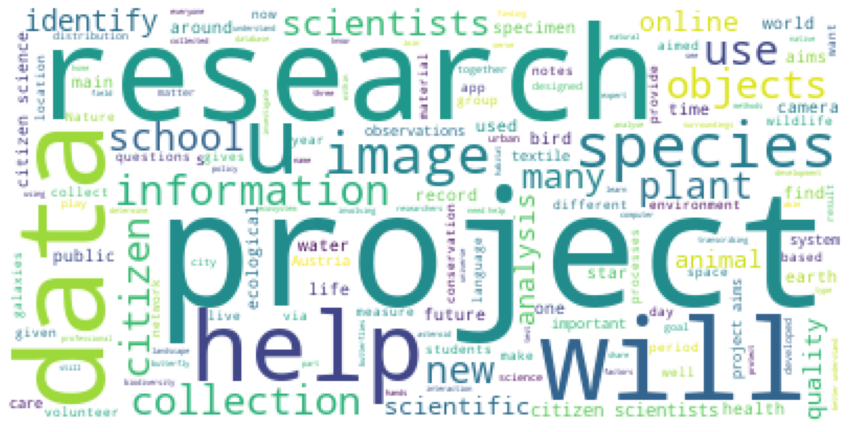

In [113]:
wordcloud = WordCloud(max_words=150, background_color="white").generate(clean_text)
plt.figure(figsize = (15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [114]:
wordcloud.to_file("WordCloud.png")